### unsupervised CVAE
- 비지도의 방식으로 CVAE를 구성했을 때, semi-supervised에 얼마나 근접할 지 알아보자.

#### 오토인코더에 컨디션을 주면 잠재 공간의 분포는 어떤 모습을 띌까?
- 각 클래스 별로 동일한 분포를 가질 것이다.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

class My_Encoder(nn.Module):
    def __init__(self, dim_encoder_output, num_class, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.l0 = nn.Linear(784 + num_class, 512)
        self.l1 = nn.Linear(512, 512)
        self.l2 = nn.Linear(512, dim_encoder_output)

    def forward(self, x, label):
        x = torch.cat([x, label], dim=1)
        h = self.activation(self.l0(x))
        h = self.activation(self.l1(h))
        z = self.l2(h)
        return z


class My_Decoder(nn.Module):
    def __init__(self, dim_decoder_input, num_class, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.l0 = nn.Linear(dim_decoder_input + num_class, 512)
        self.l1 = nn.Linear(512, 512)
        self.l2 = nn.Linear(512, 784)

    def forward(self, z, label):
        z = torch.cat([z, label], dim=1)
        x_hat = self.activation(self.l0(z))
        x_hat = self.activation(self.l1(x_hat))
        x_hat = torch.sigmoid(self.l2(x_hat))
        return x_hat


In [2]:
from myAE import Manager

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(2, 10), My_Decoder(2, 10))

def calc_loss(model, x, y, F, device):
    label = F.one_hot(y, 10)
    z = model.get_submodule("encoder")(x, label)
    x_hat = model.get_submodule("decoder")(z, label)
    loss = F.binary_cross_entropy(x_hat, x, reduction='sum')/len(x)
    return loss

def encode(model, x, y):
    label = F.one_hot(y, 10)
    z = model.get_submodule("encoder")(x, label)
    return [z]

hist, record = manager.train_with_record(calc_loss, encode, 0.2, epochs=30)

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Now, it is working on cuda:1.


100%|██████████| 30/30 [02:27<00:00,  4.91s/it]


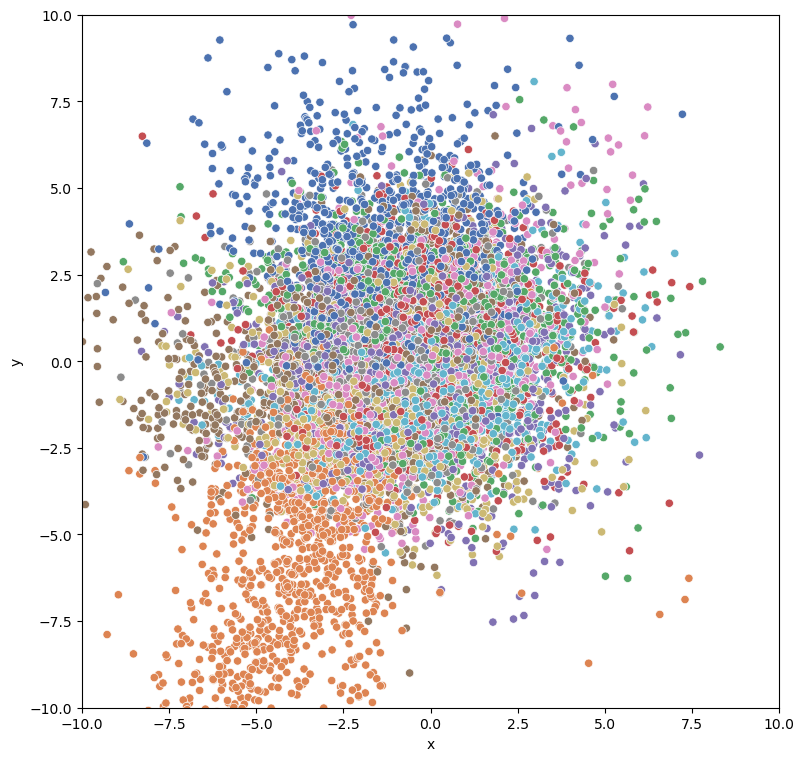

In [3]:
manager.make_video_of('cae_30_epochs', record)

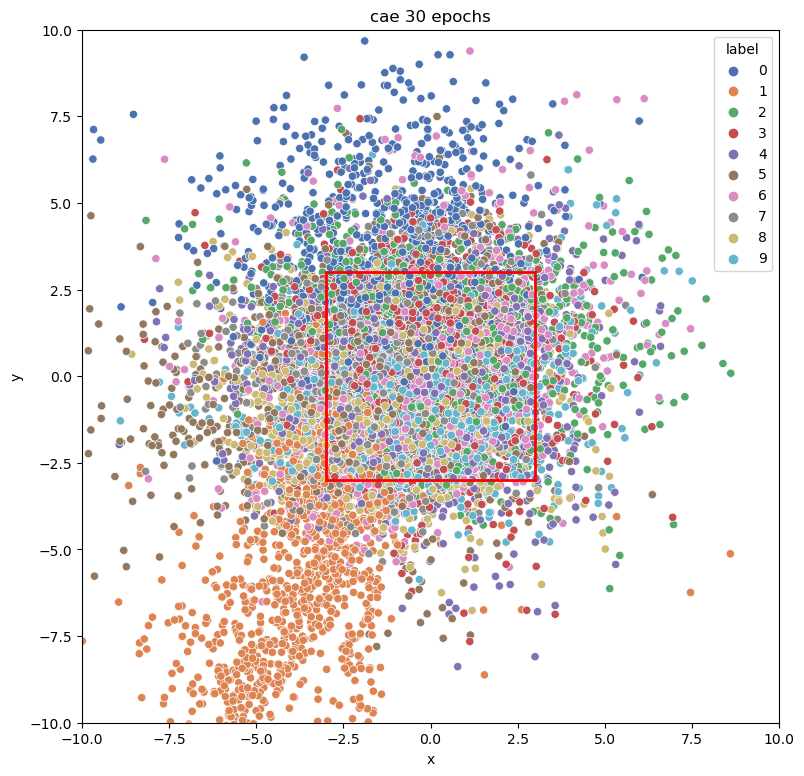

In [4]:
manager.show_latent_space('cae 30 epochs', encode)

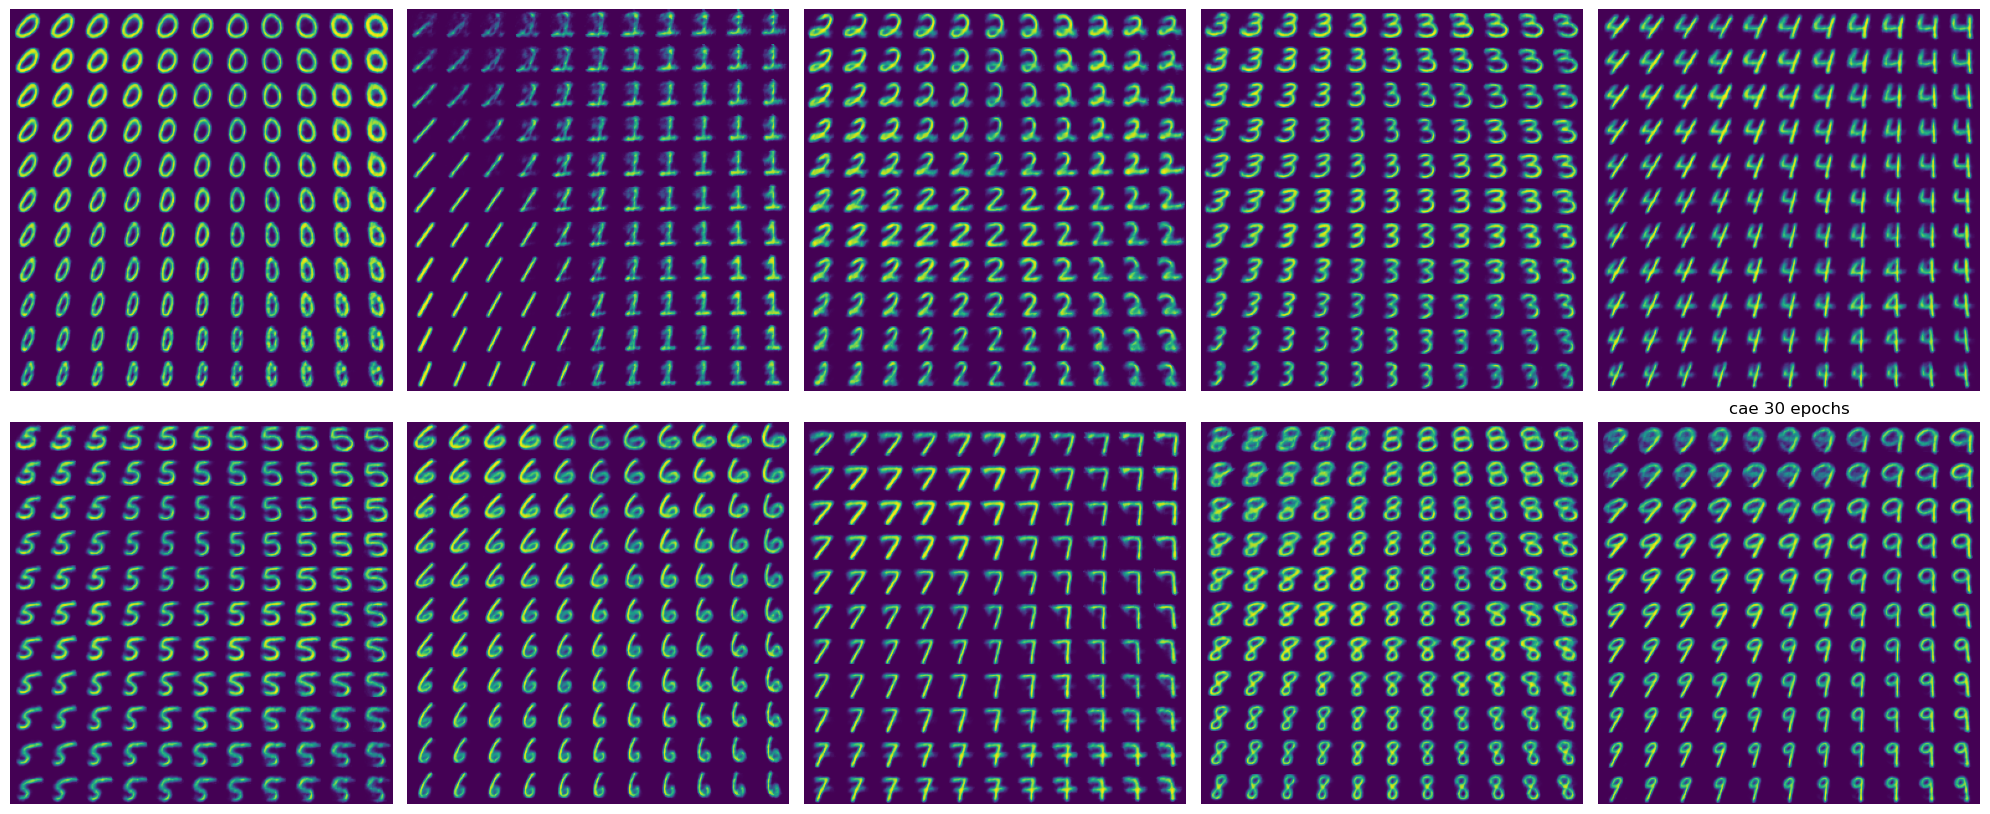

In [5]:
manager.plot_generated_images_for_10_classes('cae 30 epochs')

#### 오토 인코더에 컨디션을 추가했을 때...
- 실험을 해 보기 전에는, 각 클래스별 분포가 동일하리라고 예상했지만 실험에서 나타난 결과는 서로 다른 분포를 보였다.
- 오토 인코더의 손실 함수는 입력과 출력 간의 오차를 평가한다. 따라서 실험에서 나타난 결과로 짐작할 수 있는 사실은 클래스 마다 서로 다른 분포를 가지는 것이 더나은 출력을 만드는 방식(주어진 구조의 오토 인코더가)이라는 것이다. 

#### 오토인코더를 사용한 클러스터링
- 라벨을 추정하는 네트워크와 오토인코더를 한 묶음으로 사용했을 때 발생할 예상 문제점
    - 우리가 원하는 꽤 정확한 군집화가 이루어 지지 못하게 방해할 수 있는 취약한 지점은, 학습이 진행되면서 오토인코더의 복원 능력이 클래스를 예측하는 네트워크에 수렴하면서 더 이상 나은 결과로 진행하지 못 하게끔 서로를 묶어 두는 형국이 될 수 있다는 점이다.
    - 위와 같은 상황을 다시 한번 상상해 본다면, 오토인코더가 해당 라벨에 대하여 최대한 성능으로 맞추어지고, 군집 예측 네트워크는 오토인코더(10)가 제시하는 가 답안을 이미 예측한 상태에서 오토인토더의 상태에 변화를 이끌어 낼 만한 라벨을 만들어 내지 못 하는 상황이 된다는 것이다.
    - 한 하지 도전해 볼만한 방식은 예측을 담당하는 네트워크의 출력을 단순히 하나의 고정된 값이 아니라 임의적인 변동이 가능한 확률 분포로 해석을 하고, 샘플링 방식을 사용하는 것이다.
- 그렇다면 이렇게 형성된 예측 네트워크를 새로운 초기 설정의 오토인코더에 다시금 적용하면 어떤 일이 생길까?
    - ... 이 것은 다음에 생각하고...

#### 훈련된 CAE에 틀린 라벨의 데이터를 넣으면 어떻게 될까?
- 당연히 틀린 라벨의 숫자로 복원을 한다.
- 결과는 0인 입력에 대하여 다른 9가지의 라벨로 실험을 했을 때,
    - 잠재 공간으로의 사상은 라벨의 영향보다는 이미지의 영향을 크게 받아서 0이 주로 사상되는 위치로 치우쳐 나타났다.
    - 그리고 복원은 라벨에 의해 영향을 받아서 틀린 라벨의 이미지를 생성했다.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

class My_Encoder(nn.Module):
    def __init__(self, dim_encoder_output, num_class, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.l0 = nn.Linear(784 + num_class, 512)
        self.l1 = nn.Linear(512, 512)
        self.l2 = nn.Linear(512, dim_encoder_output)

    def forward(self, x, label):
        x = torch.cat([x, label], dim=1)
        h = self.activation(self.l0(x))
        h = self.activation(self.l1(h))
        z = self.l2(h)
        return z


class My_Decoder(nn.Module):
    def __init__(self, dim_decoder_input, num_class, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.l0 = nn.Linear(dim_decoder_input + num_class, 512)
        self.l1 = nn.Linear(512, 512)
        self.l2 = nn.Linear(512, 784)

    def forward(self, z, label):
        z = torch.cat([z, label], dim=1)
        x_hat = self.activation(self.l0(z))
        x_hat = self.activation(self.l1(x_hat))
        x_hat = torch.sigmoid(self.l2(x_hat))
        return x_hat

from myAE import Manager

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(2, 10), My_Decoder(2, 10))

def calc_loss(model, x, y, F, device):
    label = F.one_hot(y, 10)
    z = model.get_submodule("encoder")(x, label)
    x_hat = model.get_submodule("decoder")(z, label)
    loss = F.binary_cross_entropy(x_hat, x, reduction='sum')/len(x)
    return loss

hist = manager.train(calc_loss, 10)

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Now, it is working on cuda:0.


100%|██████████| 10/10 [00:48<00:00,  4.90s/it]


In [9]:
manager.model.eval()
manager.model.to('cpu')

with torch.no_grad():
  for x, y in manager.train_dataloader:
    x = x[0].view(1, 28 * 28)
    x = torch.cat([x] * 9)
    tmp_t = torch.arange(10)
    tmp_ys = tmp_t[tmp_t != y[0]]
    label = F.one_hot(tmp_ys, 10)
    z = manager.model.get_submodule("encoder")(x, label)
    x_hat = manager.model.get_submodule("decoder")(z, label)  

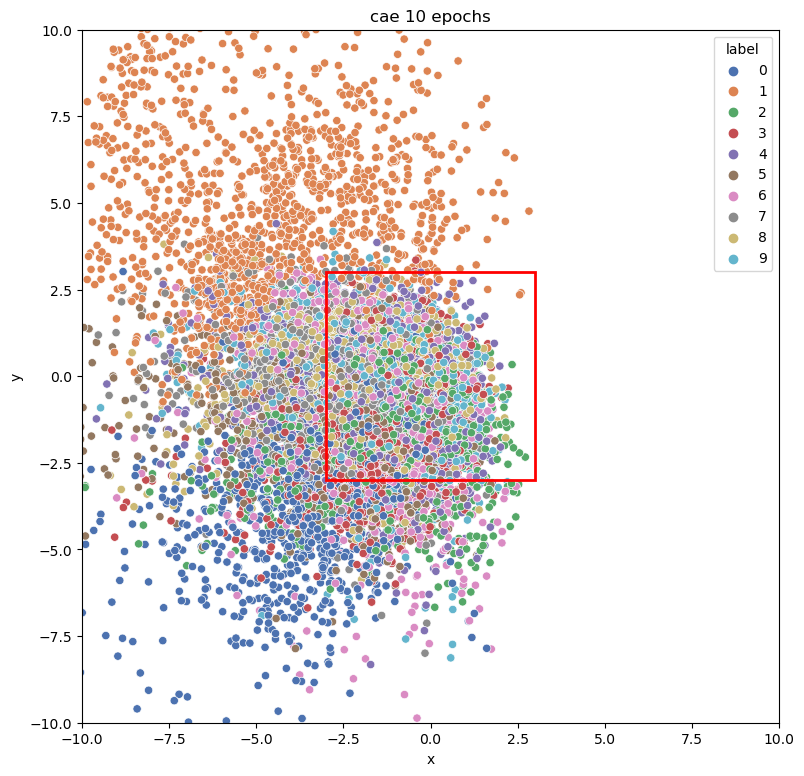

In [13]:
def encode(model, x, y):
    label = F.one_hot(y, 10)
    z = model.get_submodule("encoder")(x, label)
    return [z]

manager.show_latent_space('cae 10 epochs', encode)

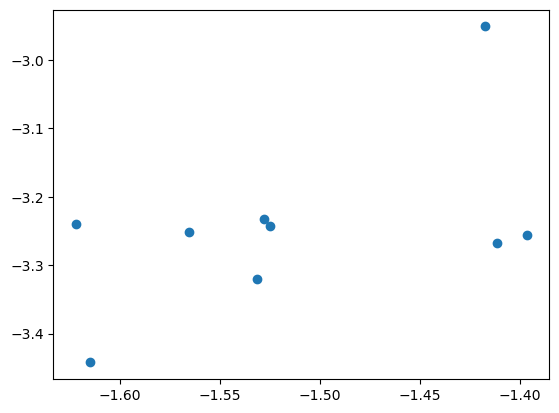

In [11]:
import matplotlib.pyplot as plt
plt.scatter(z[:, 0], z[:, 1])
plt.show()

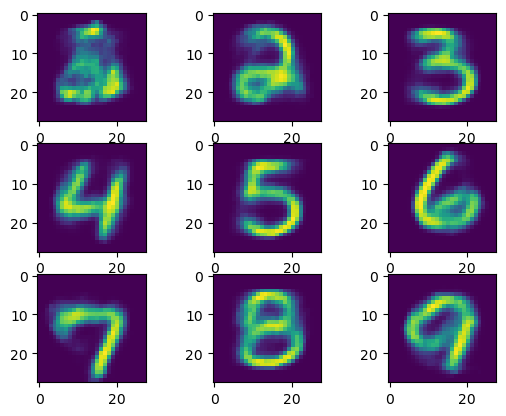

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3)

for ax, img in zip(axs.flat, x_hat):
    ax.imshow(img.view(28, 28))

plt.show()


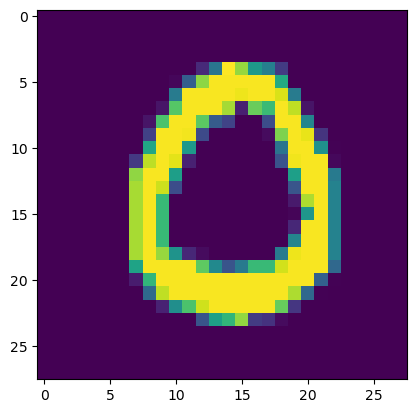

In [16]:
plt.imshow(x[0].view(28, 28))